In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.playerdashboardbyshootingsplits import PlayerDashboardByShootingSplits


In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:

import matplotlib.pyplot as plt
import pandas as pd
from math import pi

def plot_radar(
    title,
    data,
    labels,
    colors,
    alphas,
    ax=None
):
    # number of variable
    categories=list(data[0].tolist())
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    if ax is None:
        fig = plt.figure(figsize=(12, 12))
        ax = plt.subplot(111, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([item.replace("_", " ") for item in data[0].index.tolist()])
    for label,i in zip(ax.get_xticklabels(),range(0,len(angles))):

        angle_rad=angles[i]
        if angle_rad <= pi/2:
            ha= 'left'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)+90
        elif pi/2 < angle_rad <= pi:
            ha= 'left'
            va= "top"
            angle_text=angle_rad*(-180/pi)+90
        elif pi < angle_rad <= (3*pi/2):
            ha= 'right'
            va= "top"  
            angle_text=angle_rad*(-180/pi)-90
        else:
            ha= 'right'
            va= "bottom"
            angle_text=angle_rad*(-180/pi)-90
        label.set_rotation(angle_text)
        label.set_verticalalignment(va)
        label.set_horizontalalignment(ha)


    # Draw ylabels
    ax.set_rlabel_position(0)
    #items = [item / 10 for item in range(0, 55, 10)]
    #plt.yticks(items, map(str, items), size=12)
    #ax.spines['polar'].set_color('#cbcbcb')
    #ax.spines['polar'].set_linewidth('1')
    
    max_val = max([item.max() for item in data])
    ax.set_ylim(0, max_val)
    ax.spines['polar'].set_visible(False)

    ax.set_title(title, color='black', size=20, pad=20)
    
    for i in range(len(data)):
    
        cur_data = data[i]
        values=cur_data.tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=labels[i], color=colors[i])
        ax.fill(angles, values, colors[i], alpha=alphas[i])
    
    legend = ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    
    #ax.set_yticks([item for item in range(0, 45, 10)])
    #ax.set_yticklabels([f"{item}" for item in range(0, 45, 10)], size=12)


    ax.set_frame_on(False)
    ax.set_axisbelow(True)
    #ax.set_facecolor(bball_gray)
    #fig.set_facecolor(bball_gray)

In [7]:
play_types = [
    "PRBallHandler",
    "Isolation",
    "Transition",
    "Spotup",
    "Handoff",
    "OffScreen",
    "Cut",
    "OffRebound",
    "Postup",
    "PRRollman",
]

play_types_seasons = {}


    
def download_play_type_data(season='2019-20'):
    
    play_type_dict = {}
    if season not in play_types_seasons:
        print("Retrieving play types...")
        for play in play_types:
            synergy = SynergyPlayTypes(player_or_team_abbreviation='P', play_type_nullable=play, type_grouping_nullable="offensive", per_mode_simple="PerGame", season=season)
            synergy_df = synergy.get_data_frames()[0]
            play_type_dict[play] = synergy_df
            time.sleep(1)
        play_types_seasons[season] = play_type_dict
    else:
        play_type_dict = play_types_seasons[season]

    
    return play_type_dict




In [8]:
def get_interesting_data(df, target_column):
    final_df = None
    for index, play in enumerate(play_types):
        columns = ["PLAYER_NAME", target_column]
        result = df[play].loc[:, columns]
        result = result.rename(columns={target_column: f'{target_column}_{play}'})
        if index == 0:
            final_df = result
        else:
            final_df = pd.merge(left=final_df, right=result, on='PLAYER_NAME', how='outer')
    return final_df


def get_merged_data(first_year, second_year, target_column):
    
    target_columns = [
        f"{target_column}_PRBallHandler",
        f"{target_column}_Isolation",
        f"{target_column}_Transition",
        f"{target_column}_Spotup",
        f"{target_column}_Handoff",
        f"{target_column}_OffScreen",
        f"{target_column}_Cut",
        f"{target_column}_OffRebound",
        f"{target_column}_Postup",
        f"{target_column}_PRRollman",
    ]

    
    
    first_df = get_interesting_data(first_year, target_column)
    second_df = get_interesting_data(second_year, target_column)
    merged_df = pd.merge(left=first_df, right=second_df, on='PLAYER_NAME', suffixes=('_last', '_cur'))
    for play in play_types:
        merged_df.loc[:, f'{play}_diff'] = (merged_df[f'{target_column}_{play}_cur'] - merged_df[f'{target_column}_{play}_last'])**2
        
    merged_df.loc[:, "LAST_NORM"] = ((merged_df.loc[:, [f"{item}_last" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    merged_df.loc[:, "CUR_NORM"] = ((merged_df.loc[:, [f"{item}_cur" for item in target_columns]]) ** 2).sum(axis=1) ** (1/2)
    
    dot_product = []
    for i in range(len(merged_df)):
        last_numpy = merged_df.loc[:, [f"{item}_last" for item in target_columns]].to_numpy()[i]
        cur_numpy = merged_df.loc[:, [f"{item}_cur" for item in target_columns]].to_numpy()[i]
        dot_product.append(last_numpy.dot(cur_numpy))
    merged_df.loc[:, "DOT_PRODUCT"] = dot_product
    return merged_df
    

## Giannis Play Type

In [9]:
df = download_play_type_data(season='2020-21')

Retrieving play types...


In [9]:
last_df = download_play_type_data(season='2019-20')

Retrieving play types...


In [83]:
two_years_df = download_play_type_data(season='2018-19')

In [11]:
df['PRBallHandler'].iloc[0]

SEASON_ID                    22020
PLAYER_ID                  1629027
PLAYER_NAME             Trae Young
TEAM_ID                 1610612737
TEAM_ABBREVIATION              ATL
TEAM_NAME            Atlanta Hawks
PLAY_TYPE            PRBallHandler
TYPE_GROUPING            Offensive
PERCENTILE                   0.773
GP                              64
POSS_PCT                     0.562
PPP                           0.98
FG_PCT                       0.435
FT_POSS_PCT                  0.149
TOV_POSS_PCT                 0.145
SF_POSS_PCT                  0.118
PLUSONE_POSS_PCT             0.018
SCORE_POSS_PCT               0.444
EFG_PCT                      0.494
POSS                          14.1
PTS                           13.9
FGM                            5.8
FGA                           10.2
FGMX                           5.8
Name: 0, dtype: object

In [85]:
data_type = 'POSS_PCT'
pt_21 = get_interesting_data(df, data_type).fillna(0.0)
pt_20 = get_interesting_data(last_df, data_type).fillna(0.0)
pt_19 = get_interesting_data(two_years_df, data_type).fillna(0.0)

In [86]:
player_name = 'Giannis Antetokounmpo'

In [87]:
giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
giannis_20 = pt_20.loc[pt_20.PLAYER_NAME == player_name]
giannis_19 = pt_19.loc[pt_19.PLAYER_NAME == player_name]

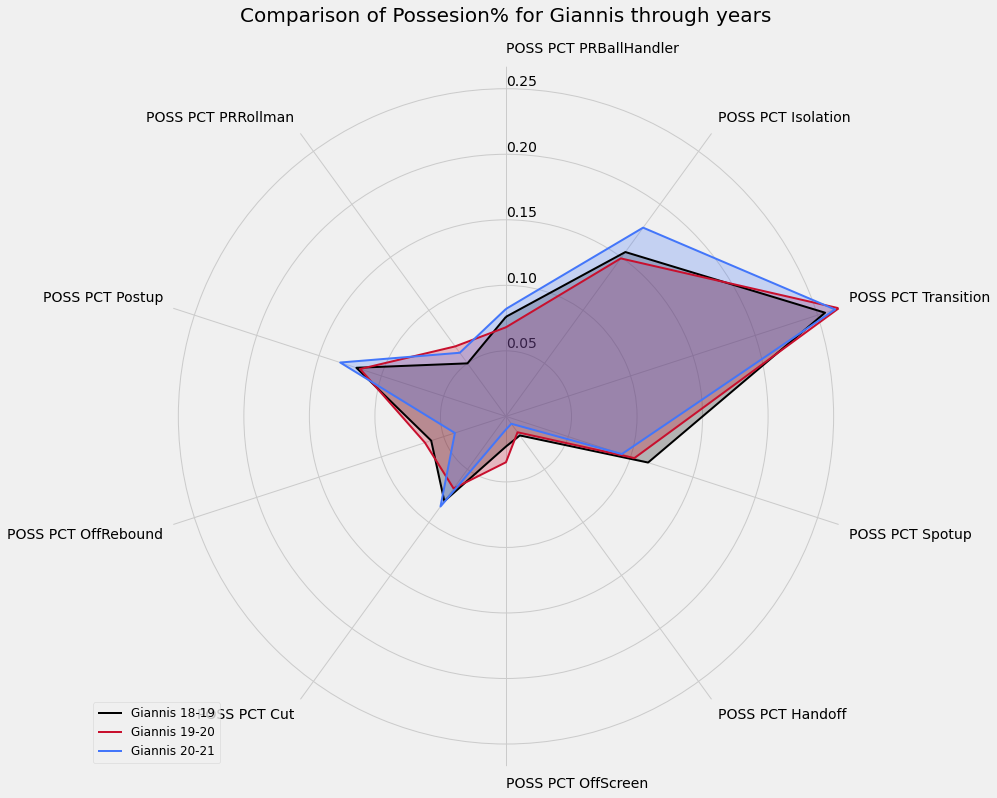

In [88]:
plot_radar(
    title="Comparison of Possesion% for Giannis through years",
    data=[giannis_19.iloc[0][1:], giannis_20.iloc[0][1:], giannis_21.iloc[0][1:]],
    labels=["Giannis 18-19", "Giannis 19-20", "Giannis 20-21"],
    colors=[
        "#000000",
        "#C8102E",
        "#4376FA"
    ],
    alphas=[0.25, 0.25, 0.25]
)

In [94]:
data_type = 'PTS'
pt_21 = get_interesting_data(df, data_type).fillna(0.0)
pt_20 = get_interesting_data(last_df, data_type).fillna(0.0)
pt_19 = get_interesting_data(two_years_df, data_type).fillna(0.0)

player_name = 'Giannis Antetokounmpo'

giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
giannis_20 = pt_20.loc[pt_20.PLAYER_NAME == player_name]
giannis_19 = pt_19.loc[pt_19.PLAYER_NAME == player_name]

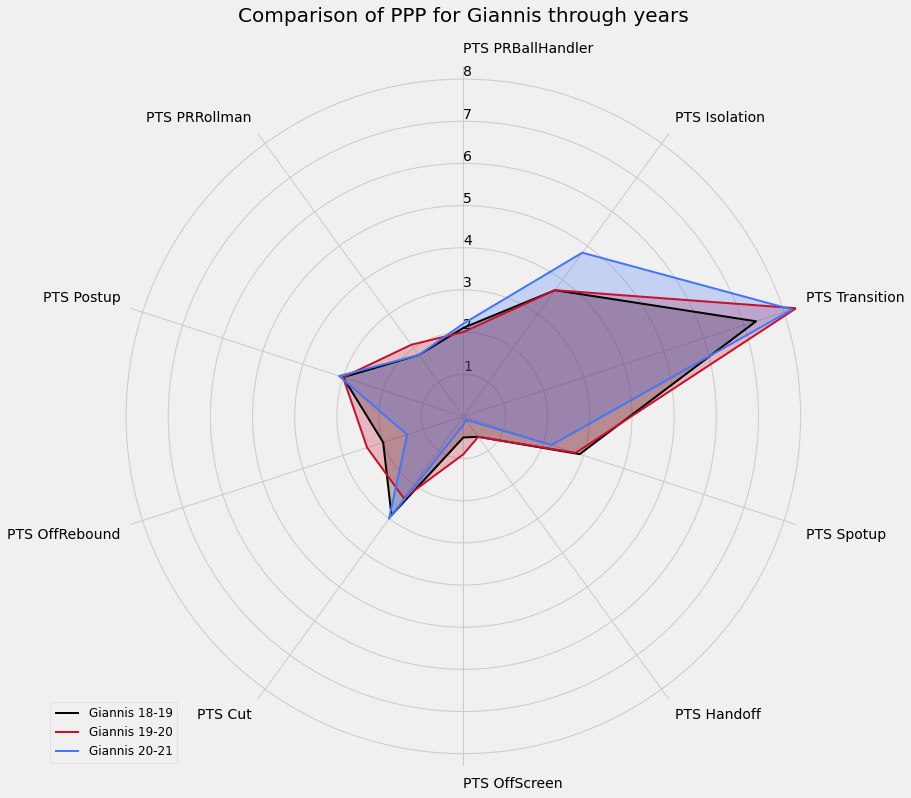

In [95]:
plot_radar(
    title="Comparison of PPP for Giannis through years",
    data=[giannis_19.iloc[0][1:], giannis_20.iloc[0][1:], giannis_21.iloc[0][1:]],
    labels=["Giannis 18-19", "Giannis 19-20", "Giannis 20-21"],
    colors=[
        "#000000",
        "#C8102E",
        "#4376FA"
    ],
    alphas=[0.25, 0.25, 0.25]
)

### Shooting Splits

In [18]:
for season in seasons:
    if season in areas_dfs:
        area_df = areas_dfs[season]
    else:
        res = PlayerDashboardByShootingSplits(player_id=player_id, season=season)
        area_df = res.get_data_frames()[3]
        area_df = area_df.loc[area_df.GROUP_VALUE != "Backcourt"]
        total_sum = area_df.FGA.sum()
        area_df.loc[:, "FGA_PCT"] = area_df.FGA / total_sum
        areas_dfs[season] = area_df
    time.sleep(0.3)

NameError: name 'seasons' is not defined

## Jrue Holiday

In [91]:
data_type = 'POSS_PCT'
pt_21 = get_interesting_data(df, data_type).fillna(0.0)
pt_20 = get_interesting_data(last_df, data_type).fillna(0.0)

player_name = 'Giannis Antetokounmpo'

jrue_df = pt_21.loc[pt_21.PLAYER_NAME == 'Jrue Holiday']
bledsoe_df = pt_20.loc[pt_20.PLAYER_NAME == 'Eric Bledsoe']

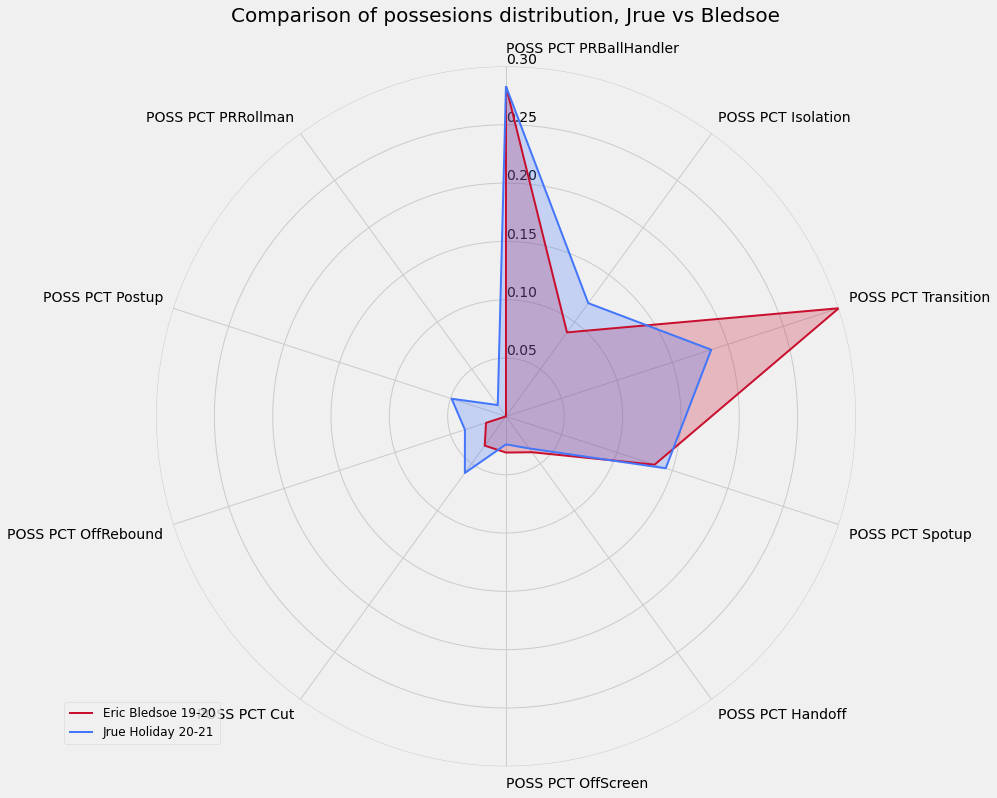

In [92]:
plot_radar(
    title="Comparison of possesions distribution, Jrue vs Bledsoe",
    data=[bledsoe_df.iloc[0][1:], jrue_df.iloc[0][1:]],
    labels=["Eric Bledsoe 19-20", "Jrue Holiday 20-21"],
    colors=[
        "#C8102E",
        "#4376FA"
    ],
    alphas=[0.25, 0.25]
)

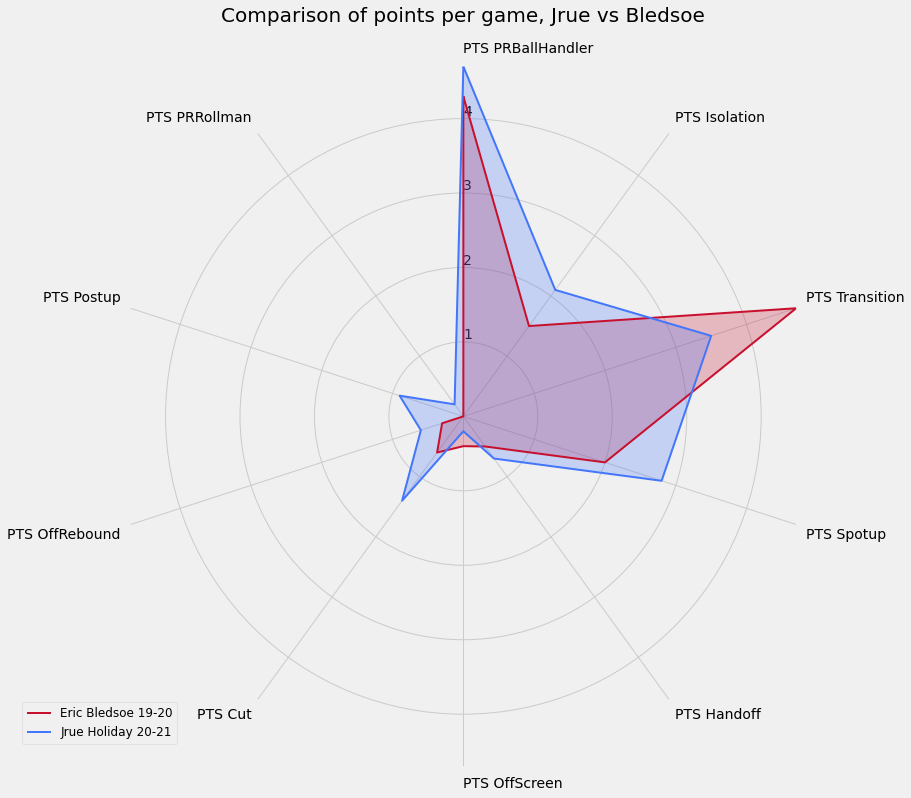

In [93]:
data_type = 'PTS'
pt_21 = get_interesting_data(df, data_type).fillna(0.0)
pt_20 = get_interesting_data(last_df, data_type).fillna(0.0)

player_name = 'Giannis Antetokounmpo'

jrue_df = pt_21.loc[pt_21.PLAYER_NAME == 'Jrue Holiday']
bledsoe_df = pt_20.loc[pt_20.PLAYER_NAME == 'Eric Bledsoe']

plot_radar(
    title="Comparison of points per game, Jrue vs Bledsoe",
    data=[bledsoe_df.iloc[0][1:], jrue_df.iloc[0][1:]],
    labels=["Eric Bledsoe 19-20", "Jrue Holiday 20-21"],
    colors=[
        "#C8102E",
        "#4376FA"
    ],
    alphas=[0.25, 0.25]
)

### Middleton

In [21]:
data_type = 'POSS_PCT'
pt_21 = get_interesting_data(df, data_type).fillna(0.0)
pt_20 = get_interesting_data(last_df, data_type).fillna(0.0)
pt_19 = get_interesting_data(two_years_df, data_type).fillna(0.0)

player_name = 'Khris Middleton'

giannis_21 = pt_21.loc[pt_21.PLAYER_NAME == player_name]
giannis_20 = pt_20.loc[pt_20.PLAYER_NAME == player_name]
giannis_19 = pt_19.loc[pt_19.PLAYER_NAME == player_name]

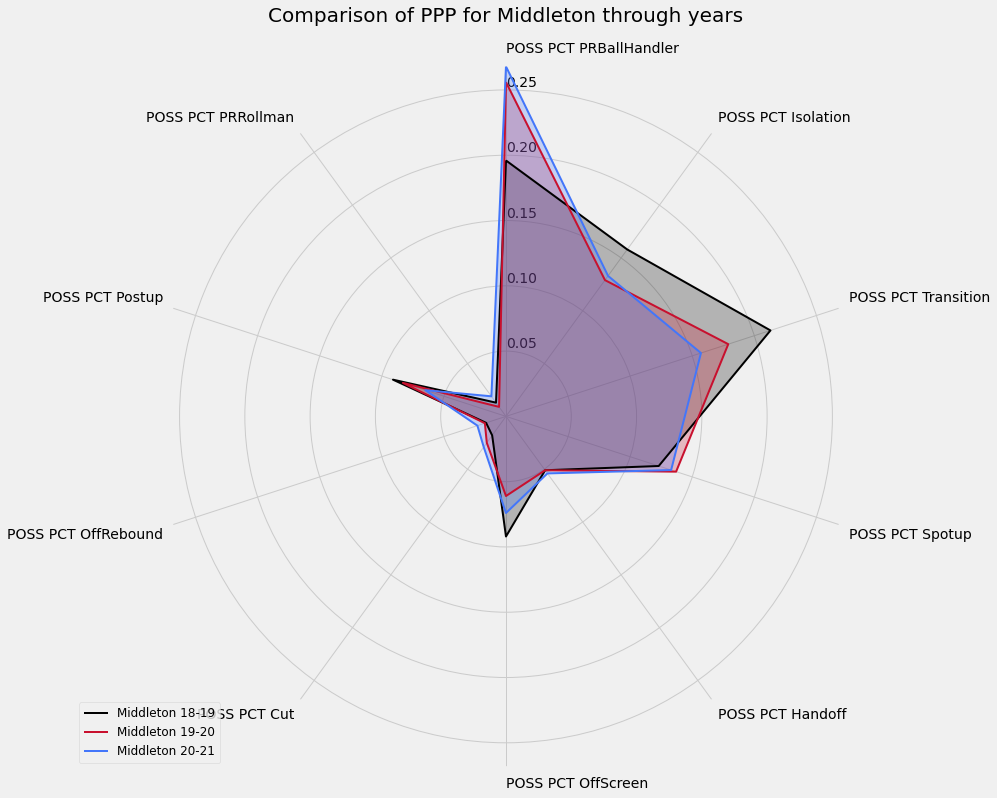

In [22]:
plot_radar(
    title="Comparison of PPP for Middleton through years",
    data=[giannis_19.iloc[0][1:], giannis_20.iloc[0][1:], giannis_21.iloc[0][1:]],
    labels=["Middleton 18-19", "Middleton 19-20", "Middleton 20-21"],
    colors=[
        "#000000",
        "#C8102E",
        "#4376FA"
    ],
    alphas=[0.25, 0.25, 0.25]
)

## Team Shooting

In [23]:
from nba_api.stats.endpoints.leaguedashteamptshot import LeagueDashTeamPtShot

In [24]:
super_early = '24-22'
very_early = '22-18 Very Early'
early = '18-15 Early'
average = '15-7 Average'
late = '7-4 Late'
very_late = '4-0 Very Late'

shot_clock_times = [
    super_early,
    very_early,
    early,
    average,
    late,
    very_late
]

super_early_str = 'SUPER_EARLY'
very_early_str = 'VERY_EARLY'
early_str = 'EARLY'
average_str = 'AVERAGE'
late_str = 'LATE'
very_late_str = 'VERY_LATE'


sc_dict = {
    super_early: super_early_str,
    very_early: very_early_str,
    early: early_str,
    average: average_str,
    late: late_str,
    very_late: very_late_str
}

In [25]:
merged_df = None
for sc_time in shot_clock_times:
    data = LeagueDashTeamPtShot(season='2020-21', shot_clock_range_nullable=sc_time).get_data_frames()[0]
    if merged_df is None:
        merged_df = data
    else:
        merged_df = pd.merge(left=merged_df, right=data, suffixes=('', f'_{sc_dict[sc_time]}'), on=('TEAM_ID', 'TEAM_NAME'))
    time.sleep(0.2)

In [26]:
merged_df.loc[:, 'TOTAL_FGA'] = merged_df.loc[:, [item for item in merged_df.columns if 'FGA' in item and 'FREQ' not in item]].sum(axis=1)

In [27]:
interesting_columns = [item for item in merged_df.columns if 'FGA' in item and 'FREQ' not in item and 'TOTAL' not in item]

In [28]:
interesting_columns

['FGA',
 'FGA_VERY_EARLY',
 'FGA_EARLY',
 'FGA_AVERAGE',
 'FGA_LATE',
 'FGA_VERY_LATE']

In [29]:
merged_df.loc[:, 'EARLY_ATTEMPTS'] = merged_df.FGA + merged_df.FGA_VERY_EARLY + merged_df.FGA_EARLY

In [30]:
merged_df.loc[:, 'LATE_ATTEMPTS'] = merged_df.FGA_LATE + merged_df.FGA_VERY_LATE

In [31]:
merged_df.loc[:, 'AVERAGE_ATTEMPTS'] = merged_df.FGA_AVERAGE

In [32]:
merged_df.loc[:, 'EARLY_MAKES'] = merged_df.FGM + merged_df.FGM_VERY_EARLY + merged_df.FGM_EARLY
merged_df.loc[:, 'LATE_MAKES'] = merged_df.FGM_LATE + merged_df.FGM_VERY_LATE
merged_df.loc[:, 'AVERAGE_MAKES'] = merged_df.FGM_AVERAGE

In [33]:
merged_df.loc[:, 'EARLY_FREQ'] = merged_df.EARLY_ATTEMPTS / merged_df.TOTAL_FGA
merged_df.loc[:, 'AVERAGE_FREQ'] = merged_df.AVERAGE_ATTEMPTS / merged_df.TOTAL_FGA
merged_df.loc[:, 'LATE_FREQ'] = merged_df.LATE_ATTEMPTS / merged_df.TOTAL_FGA

merged_df.loc[:, 'EARLY_FG_PCT'] = merged_df.EARLY_MAKES / merged_df.EARLY_ATTEMPTS
merged_df.loc[:, 'AVERAGE_FG_PCT'] = merged_df.AVERAGE_MAKES / merged_df.AVERAGE_ATTEMPTS
merged_df.loc[:, 'LATE_FG_PCT'] = merged_df.LATE_MAKES / merged_df.LATE_ATTEMPTS

## 2019-20

In [36]:
last_merged_df = None

for sc_time in shot_clock_times:
    data = LeagueDashTeamPtShot(season='2019-20', shot_clock_range_nullable=sc_time).get_data_frames()[0]
    if last_merged_df is None:
        last_merged_df = data
    else:
        last_merged_df = pd.merge(left=last_merged_df, right=data, suffixes=('', f'_{sc_dict[sc_time]}'), on=('TEAM_ID', 'TEAM_NAME'))
    time.sleep(0.2)

In [38]:
last_merged_df.loc[:, 'TOTAL_FGA'] = last_merged_df.loc[:, [item for item in last_merged_df.columns if 'FGA' in item and 'FREQ' not in item]].sum(axis=1)
last_merged_df.loc[:, 'EARLY_ATTEMPTS'] = last_merged_df.FGA + last_merged_df.FGA_VERY_EARLY + last_merged_df.FGA_EARLY

last_merged_df.loc[:, 'LATE_ATTEMPTS'] = last_merged_df.FGA_LATE + last_merged_df.FGA_VERY_LATE

last_merged_df.loc[:, 'AVERAGE_ATTEMPTS'] = last_merged_df.FGA_AVERAGE

last_merged_df.loc[:, 'EARLY_MAKES'] = last_merged_df.FGM + last_merged_df.FGM_VERY_EARLY + last_merged_df.FGM_EARLY
last_merged_df.loc[:, 'LATE_MAKES'] = last_merged_df.FGM_LATE + last_merged_df.FGM_VERY_LATE
last_merged_df.loc[:, 'AVERAGE_MAKES'] = last_merged_df.FGM_AVERAGE

last_merged_df.loc[:, 'EARLY_FREQ'] = last_merged_df.EARLY_ATTEMPTS / last_merged_df.TOTAL_FGA
last_merged_df.loc[:, 'AVERAGE_FREQ'] = last_merged_df.AVERAGE_ATTEMPTS / last_merged_df.TOTAL_FGA
last_merged_df.loc[:, 'LATE_FREQ'] = last_merged_df.LATE_ATTEMPTS / last_merged_df.TOTAL_FGA

last_merged_df.loc[:, 'EARLY_FG_PCT'] = last_merged_df.EARLY_MAKES / last_merged_df.EARLY_ATTEMPTS
last_merged_df.loc[:, 'AVERAGE_FG_PCT'] = last_merged_df.AVERAGE_MAKES / last_merged_df.AVERAGE_ATTEMPTS
last_merged_df.loc[:, 'LATE_FG_PCT'] = last_merged_df.LATE_MAKES / last_merged_df.LATE_ATTEMPTS

## 2018-19

In [56]:
df = None

for sc_time in shot_clock_times:
    data = LeagueDashTeamPtShot(season='2018-19', shot_clock_range_nullable=sc_time).get_data_frames()[0]
    if df is None:
        df = data
    else:
        df = pd.merge(left=df, right=data, suffixes=('', f'_{sc_dict[sc_time]}'), on=('TEAM_ID', 'TEAM_NAME'))
    time.sleep(0.2)

df.loc[:, 'TOTAL_FGA'] = df.loc[:, [item for item in df.columns if 'FGA' in item and 'FREQ' not in item]].sum(axis=1)
df.loc[:, 'EARLY_ATTEMPTS'] = df.FGA + df.FGA_VERY_EARLY + df.FGA_EARLY

df.loc[:, 'LATE_ATTEMPTS'] = df.FGA_LATE + df.FGA_VERY_LATE

df.loc[:, 'AVERAGE_ATTEMPTS'] = df.FGA_AVERAGE

df.loc[:, 'EARLY_MAKES'] = df.FGM + df.FGM_VERY_EARLY + df.FGM_EARLY
df.loc[:, 'LATE_MAKES'] = df.FGM_LATE + df.FGM_VERY_LATE
df.loc[:, 'AVERAGE_MAKES'] = df.FGM_AVERAGE

df.loc[:, 'EARLY_FREQ'] = df.EARLY_ATTEMPTS / df.TOTAL_FGA
df.loc[:, 'AVERAGE_FREQ'] = df.AVERAGE_ATTEMPTS / df.TOTAL_FGA
df.loc[:, 'LATE_FREQ'] = df.LATE_ATTEMPTS / df.TOTAL_FGA

df.loc[:, 'EARLY_FG_PCT'] = df.EARLY_MAKES / df.EARLY_ATTEMPTS
df.loc[:, 'AVERAGE_FG_PCT'] = df.AVERAGE_MAKES / df.AVERAGE_ATTEMPTS
df.loc[:, 'LATE_FG_PCT'] = df.LATE_MAKES / df.LATE_ATTEMPTS

In [40]:
last_merged_df.loc[:, 'SEASON'] = '2019-20'
merged_df.loc[:, 'SEASON'] = '2020-21'

In [42]:
total_df = pd.merge(left=last_merged_df, right=merged_df, on=('TEAM_ID', 'TEAM_NAME'), suffixes=('_LAST', '_CUR'))

In [45]:
bucks_only = total_df.loc[total_df.TEAM_NAME == 'Milwaukee Bucks']

In [49]:
bucks_only.iloc[0].to_dict()

{'TEAM_ID': 1610612749,
 'TEAM_NAME': 'Milwaukee Bucks',
 'TEAM_ABBREVIATION_LAST': 'MIL',
 'GP_LAST': 72,
 'G_LAST': 62,
 'FGA_FREQUENCY_LAST': 0.028,
 'FGM_LAST': 97,
 'FGA_LAST': 181,
 'FG_PCT_LAST': 0.536,
 'EFG_PCT_LAST': 0.544,
 'FG2A_FREQUENCY_LAST': 0.026,
 'FG2M_LAST': 94,
 'FG2A_LAST': 172,
 'FG2_PCT_LAST': 0.547,
 'FG3A_FREQUENCY_LAST': 0.001,
 'FG3M_LAST': 3,
 'FG3A_LAST': 9,
 'FG3_PCT_LAST': 0.333,
 'TEAM_ABBREVIATION_VERY_EARLY_LAST': 'MIL',
 'GP_VERY_EARLY_LAST': 72,
 'G_VERY_EARLY_LAST': 72,
 'FGA_FREQUENCY_VERY_EARLY_LAST': 0.181,
 'FGM_VERY_EARLY_LAST': 595,
 'FGA_VERY_EARLY_LAST': 1183,
 'FG_PCT_VERY_EARLY_LAST': 0.503,
 'EFG_PCT_VERY_EARLY_LAST': 0.587,
 'FG2A_FREQUENCY_VERY_EARLY_LAST': 0.092,
 'FG2M_VERY_EARLY_LAST': 395,
 'FG2A_VERY_EARLY_LAST': 598,
 'FG2_PCT_VERY_EARLY_LAST': 0.661,
 'FG3A_FREQUENCY_VERY_EARLY_LAST': 0.09,
 'FG3M_VERY_EARLY_LAST': 200,
 'FG3A_VERY_EARLY_LAST': 585,
 'FG3_PCT_VERY_EARLY_LAST': 0.342,
 'TEAM_ABBREVIATION_EARLY_LAST': 'MIL',
 'GP_

In [57]:
bucks_two = df.loc[df.TEAM_NAME == 'Milwaukee Bucks']

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.0, 'Distribution of FGs by Milwaukee Bucks depending on shot clock')

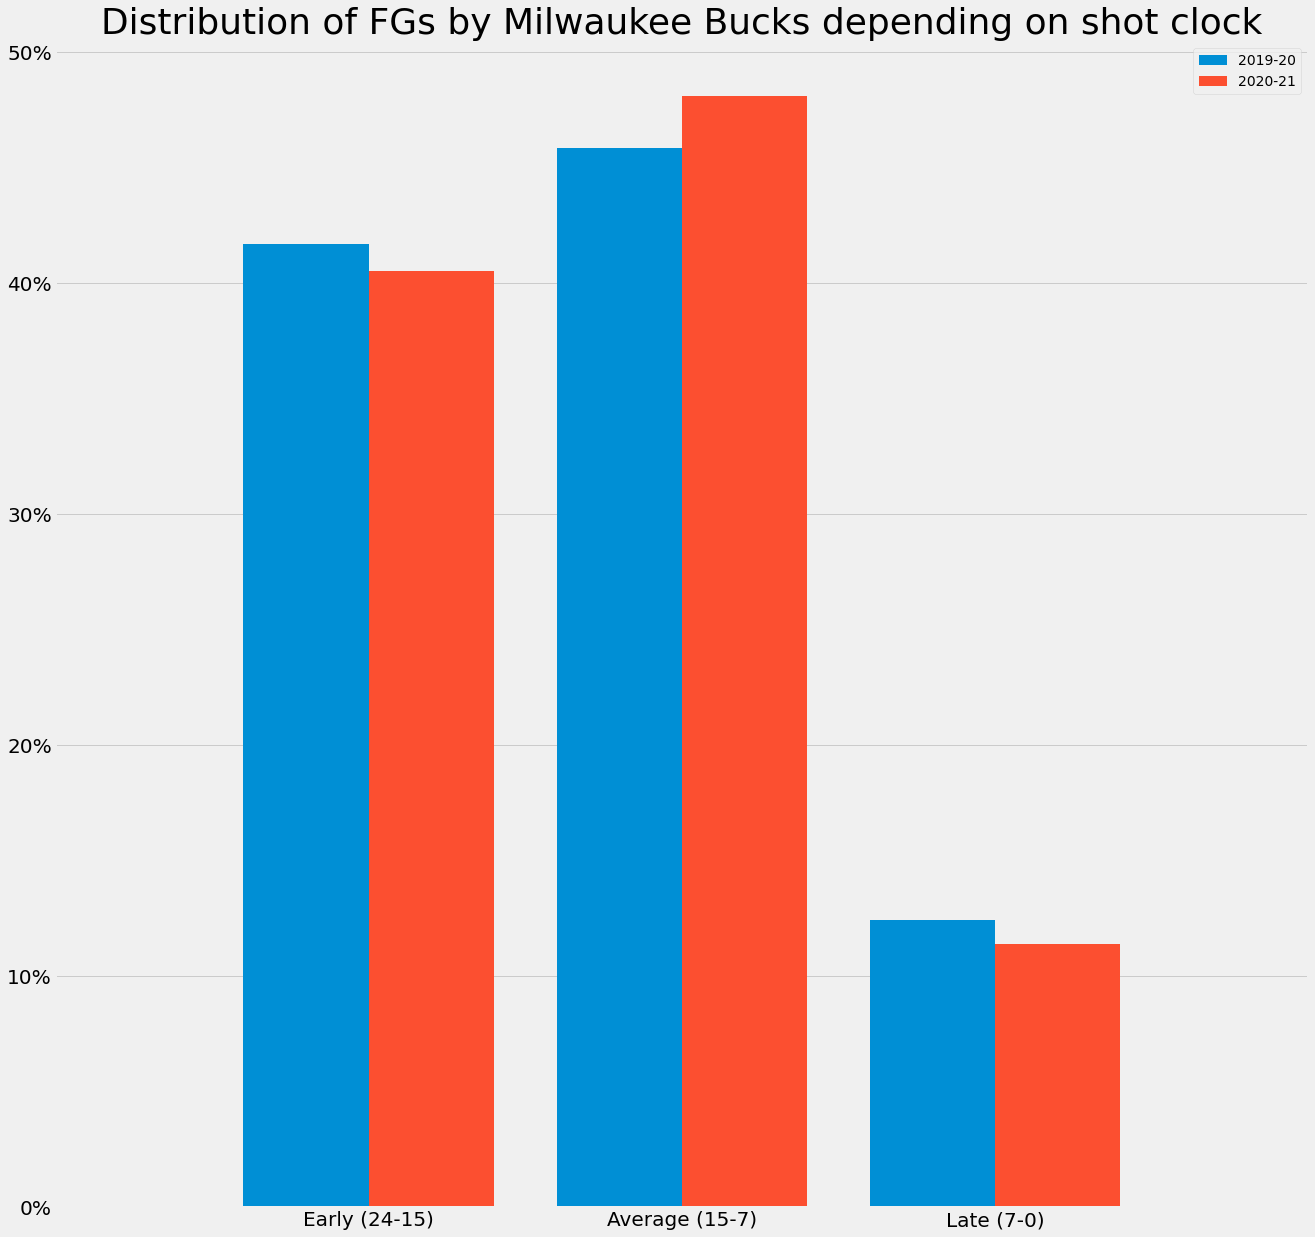

In [78]:
fig, ax = plt.subplots(figsize=(20, 20))

width = 0.4
loc_diff = 0.2
last_color = '#008fd5'
cur_color = '#fc4f30'

ax.bar(x=1-loc_diff, height=bucks_only.EARLY_FREQ_LAST * 100, width=width, color=last_color, label='2019-20')
ax.bar(x=1+loc_diff, height=bucks_only.EARLY_FREQ_CUR * 100, width=width, color=cur_color, label='2020-21')

ax.bar(x=2-loc_diff, height=bucks_only.AVERAGE_FREQ_LAST * 100, width=width, color=last_color)
ax.bar(x=2+loc_diff, height=bucks_only.AVERAGE_FREQ_CUR * 100, width=width, color=cur_color)

ax.bar(x=3-loc_diff, height=bucks_only.LATE_FREQ_LAST * 100, width=width, color=last_color)
ax.bar(x=3+loc_diff, height=bucks_only.LATE_FREQ_CUR * 100, width=width, color=cur_color)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_xticklabels(["", "Early (24-15)", "Average (15-7)", "Late (7-0)", ""])
ax.set_yticklabels([f"{item}%" for item in range(0, 60, 10)])
ax.tick_params(labelsize=20)
ax.grid(False, axis='x')
ax.legend()
ax.set_title("Distribution of FGs by Milwaukee Bucks depending on shot clock", size=36)

## Gianni Shooting

In [98]:
player_id = find_players_by_full_name("Giannis Antetokounmpo")[0]['id']

In [99]:
player_id

203507

In [101]:
seasons = ['2018-19', '2019-20', '2020-21']

In [119]:
area_dfs = []
type_dfs = []
detailed_dfs = []
for season in seasons:
    
    res = PlayerDashboardByShootingSplits(player_id=player_id, season=season)
    area_df = res.get_data_frames()[3]
    area_df = area_df.loc[area_df.GROUP_VALUE != "Backcourt"]
    total_sum = area_df.FGA.sum()
    area_df.loc[:, "FGA_PCT"] = area_df.FGA / total_sum
    type_df = res.get_data_frames()[5]
    detailed_df = res.get_data_frames()[6]
    area_df.loc[:, 'SEASON'] = season
    type_df.loc[:, 'SEASON'] = season
    detailed_df.loc[:, 'SEASON'] = season
    
    area_dfs.append(area_df)
    type_dfs.append(type_df)
    detailed_dfs.append(detailed_df)
    time.sleep(0.3)


In [125]:
full_detail = pd.concat(detailed_dfs)
full_area = pd.concat(area_dfs)
full_type = pd.concat(type_dfs)

In [127]:
for season in seasons:
    data = full_area.loc[full_area.SEASON == season]

In [129]:
first = full_area.loc[full_area.SEASON == '2018-19']
second = full_area.loc[full_area.SEASON == '2019-20']
third = full_area.loc[full_area.SEASON == '2020-21']

In [131]:
first

,GROUP_SET,GROUP_VALUE,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,EFG_PCT,BLKA,...,PCT_AST_2PM_RANK,PCT_UAST_2PM_RANK,PCT_AST_3PM_RANK,PCT_UAST_3PM_RANK,PCT_AST_FGM_RANK,PCT_UAST_FGM_RANK,CFID,CFPARAMS,FGA_PCT,SEASON
0,Shot Area,Restricted Area,567,769,0.737,0,0,0.000,0.737,71,...,1,1,3,2,3,1,49,Restricted Area,0.617175,2018-19
1,Shot Area,In The Paint (Non-RA),62,161,0.385,0,0,0.000,0.385,29,...,2,2,3,2,4,2,49,In The Paint (Non-RA),0.129213,2018-19
2,Shot Area,Mid-Range,40,116,0.345,0,2,0.000,0.345,0,...,3,3,3,2,5,3,49,Mid-Range,0.093098,2018-19
3,Shot Area,Left Corner 3,2,6,0.333,2,6,0.333,0.500,0,...,4,4,1,2,1,5,49,Left Corner 3,0.004815,2018-19
4,Shot Area,Right Corner 3,0,3,0.000,0,3,0.000,0.000,0,...,4,4,3,2,6,5,49,Right Corner 3,0.002408,2018-19
5,Shot Area,Above the Break 3,50,191,0.262,50,191,0.262,0.393,0,...,4,4,2,1,2,4,49,Above the Break 3,0.153291,2018-19


In [151]:
first.GROUP_VALUE.unique()

array(['Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range',
       'Left Corner 3', 'Right Corner 3', 'Above the Break 3'],
      dtype=object)

In [152]:
interesting_keys = [
    'Restricted Area', 'In The Paint (Non-RA)', 'Mid-Range', 'Above the Break 3'
]

In [155]:
first_total = first.loc[first.GROUP_VALUE.isin(interesting_keys)].FGA.sum()
second_total = second.loc[second.GROUP_VALUE.isin(interesting_keys)].FGA.sum()
third_total = third.loc[third.GROUP_VALUE.isin(interesting_keys)].FGA.sum()

In [160]:
first_ratios = first.loc[first.GROUP_VALUE.isin(interesting_keys)]
first_ratios.loc[:, 'FGA_PCT'] = first_ratios.FGA / first_total * 100

second_ratios = second.loc[second.GROUP_VALUE.isin(interesting_keys)]
second_ratios.loc[:, 'FGA_PCT'] = second_ratios.FGA / second_total * 100

third_ratios = third.loc[third.GROUP_VALUE.isin(interesting_keys)]
third_ratios.loc[:, 'FGA_PCT'] = third_ratios.FGA / third_total * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [164]:
first.loc[:, 'FGA_PCT'] = first.FGA_PCT * 100
second.loc[:, 'FGA_PCT'] = second.FGA_PCT * 100
third.loc[:, 'FGA_PCT'] = third.FGA_PCT * 100

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


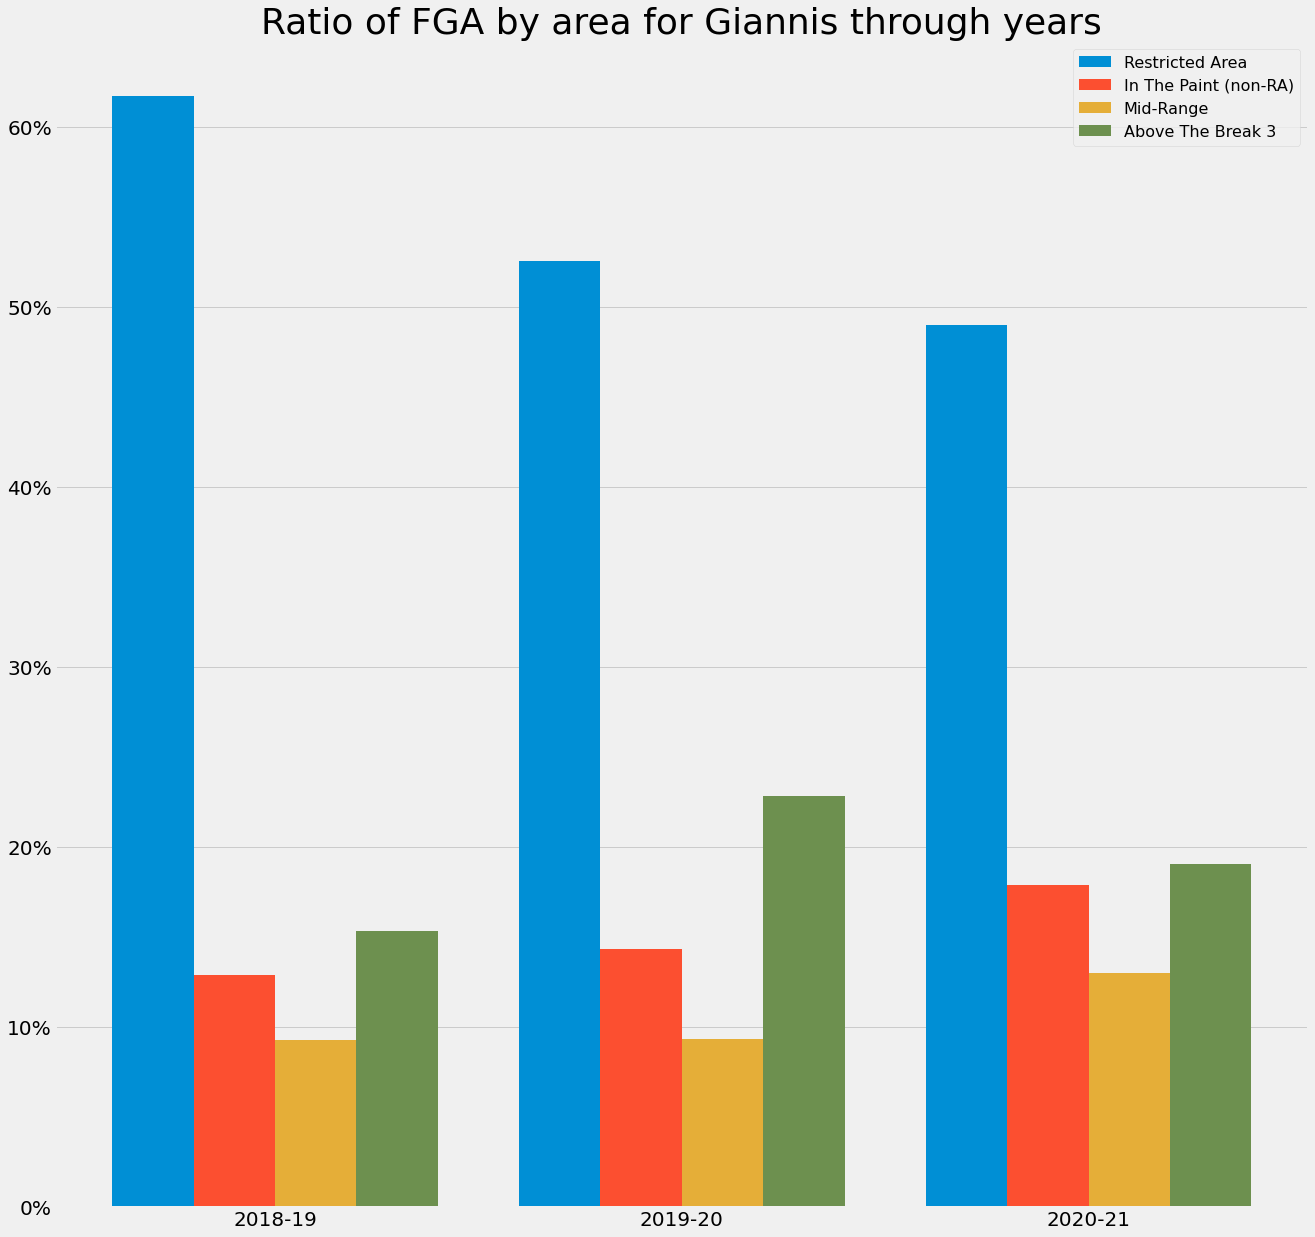

In [166]:
fig, ax = plt.subplots(figsize=(20, 20))

width = 0.2
loc_diff = 0.2
first_col = '#008fd5'
second_col = '#fc4f30'
third_col = '#e5ae38'
fourth_col = '#6d904f'


ax.bar(x=1 - 1.5 * width, height=first.loc[first.GROUP_VALUE == 'Restricted Area'].FGA_PCT, width=width, color=first_col, label='Restricted Area')
ax.bar(x=1 - 0.5 * width, height=first.loc[first.GROUP_VALUE == 'In The Paint (Non-RA)'].FGA_PCT, width=width, color=second_col, label='In The Paint (non-RA)')
ax.bar(x=1 + 0.5 * width, height=first.loc[first.GROUP_VALUE == 'Mid-Range'].FGA_PCT, width=width, color=third_col, label='Mid-Range')
ax.bar(x=1 + 1.5 * width, height=first.loc[first.GROUP_VALUE == 'Above the Break 3'].FGA_PCT, width=width, color=fourth_col, label='Above The Break 3')

ax.bar(x=2 - 1.5 * width, height=second.loc[second.GROUP_VALUE == 'Restricted Area'].FGA_PCT, width=width, color=first_col)
ax.bar(x=2 - 0.5 * width, height=second.loc[second.GROUP_VALUE == 'In The Paint (Non-RA)'].FGA_PCT, width=width, color=second_col)
ax.bar(x=2 + 0.5 * width, height=second.loc[second.GROUP_VALUE == 'Mid-Range'].FGA_PCT, width=width, color=third_col)
ax.bar(x=2 + 1.5 * width, height=second.loc[second.GROUP_VALUE == 'Above the Break 3'].FGA_PCT, width=width, color=fourth_col)

ax.bar(x=3 - 1.5 * width, height=third.loc[third.GROUP_VALUE == 'Restricted Area'].FGA_PCT, width=width, color=first_col)
ax.bar(x=3 - 0.5 * width, height=third.loc[third.GROUP_VALUE == 'In The Paint (Non-RA)'].FGA_PCT, width=width, color=second_col)
ax.bar(x=3 + 0.5 * width, height=third.loc[third.GROUP_VALUE == 'Mid-Range'].FGA_PCT, width=width, color=third_col)
ax.bar(x=3 + 1.5 * width, height=third.loc[third.GROUP_VALUE == 'Above the Break 3'].FGA_PCT, width=width, color=fourth_col)

ax.legend(fontsize=16)
ax.grid(False, axis='x')
ax.set_title("Ratio of FGA by area for Giannis through years", size=36)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["2018-19", "2019-20", "2020-21"])
ax.set_yticklabels([f"{item}%" for item in range(0, 70, 10)])
ax.tick_params(labelsize=20)

## FG% through years

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


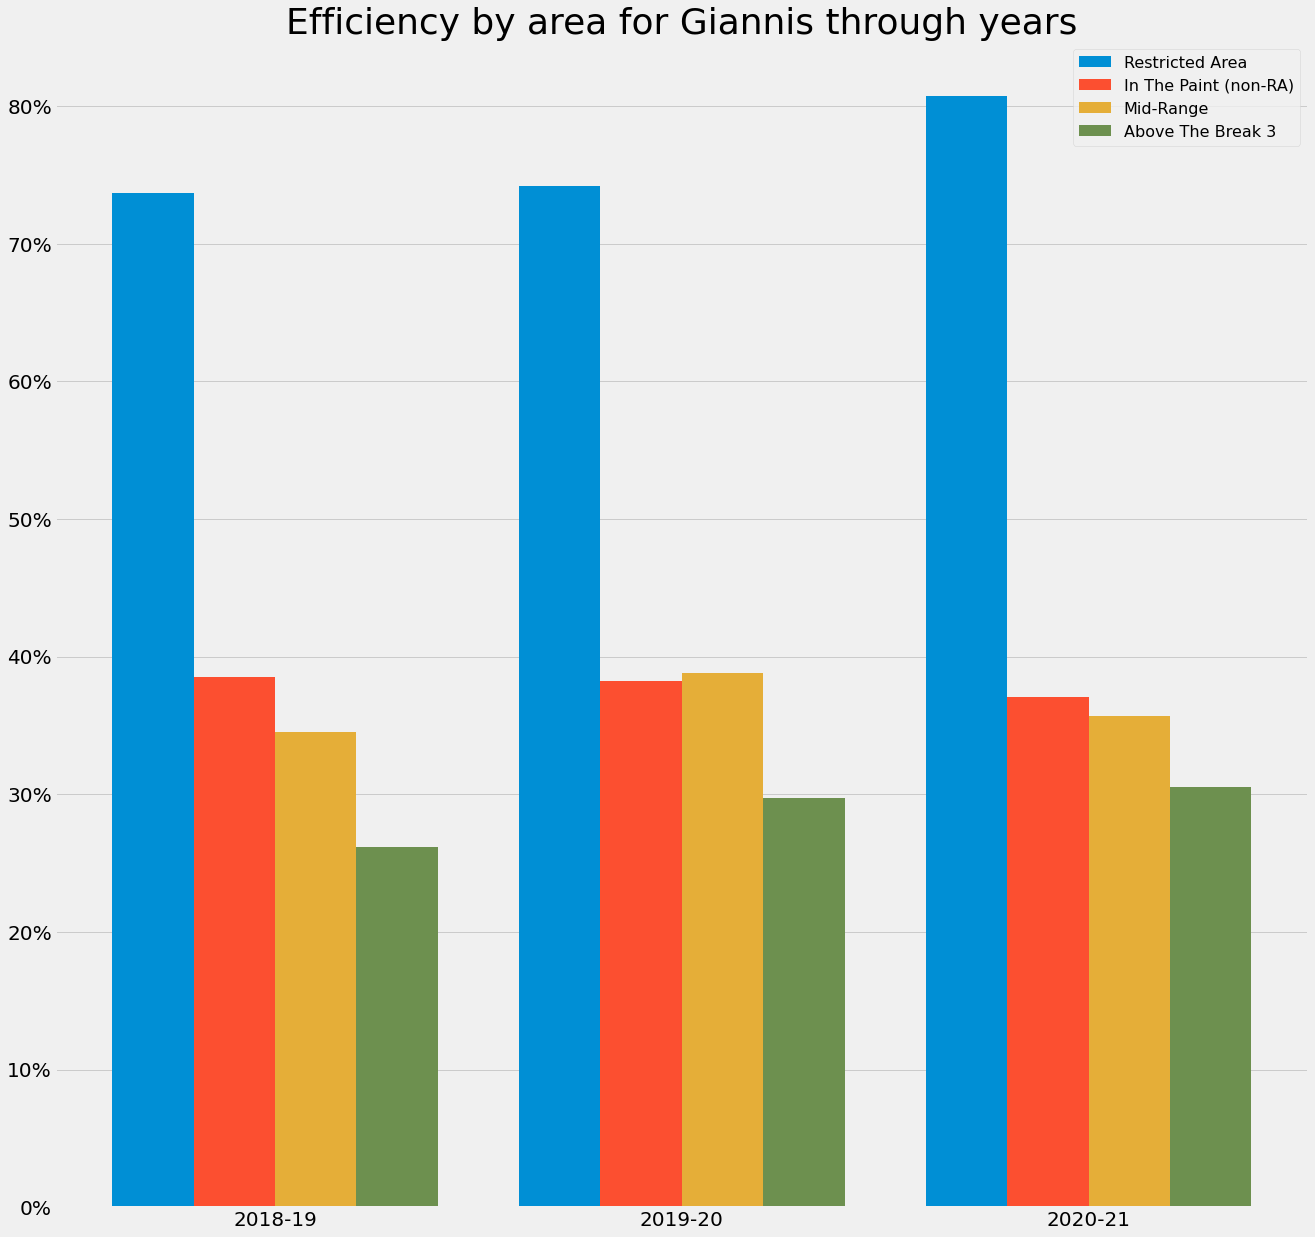

In [169]:
fig, ax = plt.subplots(figsize=(20, 20))

width = 0.2
loc_diff = 0.2
first_col = '#008fd5'
second_col = '#fc4f30'
third_col = '#e5ae38'
fourth_col = '#6d904f'


ax.bar(x=1 - 1.5 * width, height=first.loc[first.GROUP_VALUE == 'Restricted Area'].FG_PCT, width=width, color=first_col, label='Restricted Area')
ax.bar(x=1 - 0.5 * width, height=first.loc[first.GROUP_VALUE == 'In The Paint (Non-RA)'].FG_PCT, width=width, color=second_col, label='In The Paint (non-RA)')
ax.bar(x=1 + 0.5 * width, height=first.loc[first.GROUP_VALUE == 'Mid-Range'].FG_PCT, width=width, color=third_col, label='Mid-Range')
ax.bar(x=1 + 1.5 * width, height=first.loc[first.GROUP_VALUE == 'Above the Break 3'].FG_PCT, width=width, color=fourth_col, label='Above The Break 3')

ax.bar(x=2 - 1.5 * width, height=second.loc[second.GROUP_VALUE == 'Restricted Area'].FG_PCT, width=width, color=first_col)
ax.bar(x=2 - 0.5 * width, height=second.loc[second.GROUP_VALUE == 'In The Paint (Non-RA)'].FG_PCT, width=width, color=second_col)
ax.bar(x=2 + 0.5 * width, height=second.loc[second.GROUP_VALUE == 'Mid-Range'].FG_PCT, width=width, color=third_col)
ax.bar(x=2 + 1.5 * width, height=second.loc[second.GROUP_VALUE == 'Above the Break 3'].FG_PCT, width=width, color=fourth_col)

ax.bar(x=3 - 1.5 * width, height=third.loc[third.GROUP_VALUE == 'Restricted Area'].FG_PCT, width=width, color=first_col)
ax.bar(x=3 - 0.5 * width, height=third.loc[third.GROUP_VALUE == 'In The Paint (Non-RA)'].FG_PCT, width=width, color=second_col)
ax.bar(x=3 + 0.5 * width, height=third.loc[third.GROUP_VALUE == 'Mid-Range'].FG_PCT, width=width, color=third_col)
ax.bar(x=3 + 1.5 * width, height=third.loc[third.GROUP_VALUE == 'Above the Break 3'].FG_PCT, width=width, color=fourth_col)

ax.legend(fontsize=16)
ax.grid(False, axis='x')
ax.set_title("Efficiency by area for Giannis through years", size=36)
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["2018-19", "2019-20", "2020-21"])
ax.set_yticklabels([f"{item}%" for item in range(0, 90, 10)])
ax.tick_params(labelsize=20)

## Shooting Efficiency - tracking

In [31]:
last_cs = LeagueDashPtStats(season='2019-20', player_or_team='Player', pt_measure_type='CatchShoot', per_mode_simple='PerGame').get_data_frames()[0]

In [32]:
cur_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type='CatchShoot', per_mode_simple='PerGame').get_data_frames()[0]

In [33]:
merged_cs = pd.merge(left=last_cs, right=cur_cs, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_LAST', '_CUR'))

In [48]:
milwaukee_current = merged_cs.loc[(merged_cs.TEAM_ABBREVIATION_CUR == 'MIL') & (merged_cs.GP_CUR > 25)]

In [49]:
milwaukee_current

,PLAYER_ID,PLAYER_NAME,TEAM_ID_LAST,TEAM_ABBREVIATION_LAST,GP_LAST,W_LAST,L_LAST,MIN_LAST,CATCH_SHOOT_FGM_LAST,CATCH_SHOOT_FGA_LAST,...,L_CUR,MIN_CUR,CATCH_SHOOT_FGM_CUR,CATCH_SHOOT_FGA_CUR,CATCH_SHOOT_FG_PCT_CUR,CATCH_SHOOT_PTS_CUR,CATCH_SHOOT_FG3M_CUR,CATCH_SHOOT_FG3A_CUR,CATCH_SHOOT_FG3_PCT_CUR,CATCH_SHOOT_EFG_PCT_CUR
30,1626171,Bobby Portis,1610612752,NYK,66,21,45,21.1,1.3,3.6,...,22,20.8,1.3,2.8,0.481,3.8,1.1,2.3,0.467,0.673
40,201572,Brook Lopez,1610612749,MIL,68,53,15,26.7,1.5,4.8,...,24,27.2,1.4,3.9,0.354,4.0,1.2,3.7,0.337,0.513
44,1627854,Bryn Forbes,1610612759,SAS,63,27,36,25.1,1.8,4.7,...,25,19.3,1.9,4.2,0.463,5.8,1.9,4.1,0.463,0.689
115,1628978,Donte DiVincenzo,1610612749,MIL,66,53,13,23.0,1.0,2.7,...,22,27.5,1.4,3.7,0.382,4.3,1.4,3.7,0.381,0.571
149,203507,Giannis Antetokounmpo,1610612749,MIL,63,51,12,30.4,0.5,1.2,...,21,33.0,0.2,0.7,0.238,0.5,0.1,0.6,0.231,0.345
201,201952,Jeff Teague,1610612737,ATL,59,22,37,24.8,0.3,0.8,...,28,17.3,0.3,0.8,0.429,1.0,0.3,0.8,0.429,0.643
223,201950,Jrue Holiday,1610612740,NOP,61,26,35,34.7,0.9,2.3,...,18,32.3,0.8,2.1,0.374,2.3,0.7,2.0,0.379,0.553
228,1628382,Justin Jackson,1610612742,DAL,65,39,26,16.1,0.7,2.3,...,22,17.0,0.9,2.7,0.319,2.5,0.8,2.6,0.303,0.467
254,203114,Khris Middleton,1610612749,MIL,62,46,16,29.9,1.6,3.5,...,23,33.4,1.4,3.2,0.431,3.9,1.1,2.7,0.431,0.611
331,200782,P.J. Tucker,1610612745,HOU,72,44,28,34.3,1.6,4.2,...,25,26.1,0.8,2.3,0.333,2.3,0.7,2.2,0.322,0.488


In [50]:
player_ids = milwaukee_current.sort_values(by='MIN_CUR', ascending=False).iloc[:9].PLAYER_ID.tolist() + [202339, 202083, 201588]

In [30]:
tracking_types = [
    'CatchShoot',
    'PullUpShot',
    'Drives'
]

In [52]:
tracking_dfs = {}

for tracking_type in tracking_types:
    last_cs = LeagueDashPtStats(season='2019-20', player_or_team='Player', pt_measure_type=tracking_type, per_mode_simple='PerGame').get_data_frames()[0]
    time.sleep(0.4)
    cur_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type=tracking_type, per_mode_simple='PerGame').get_data_frames()[0]
    time.sleep(0.4)
    merged_cs = pd.merge(left=last_cs, right=cur_cs, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_LAST', '_CUR'))
    
    milwaukee_current = merged_cs.loc[merged_cs.PLAYER_ID.isin(player_ids)]
    tracking_dfs[tracking_type] = milwaukee_current
    

## Catch&Shoot Bucks

In [119]:
last_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type='CatchShoot', per_mode_simple='Totals').get_data_frames()[0]

mean_efg = (last_cs.CATCH_SHOOT_FGM.sum() + (0.5 * last_cs.CATCH_SHOOT_FG3M.sum())) / last_cs.CATCH_SHOOT_FGA.sum()

In [121]:
mean_efg

0.5574744693457879

#### Avg C&S

mean_efg = 0.557

In [81]:
cs = tracking_dfs['CatchShoot']
cs_bucks = cs.loc[:, 
    ['PLAYER_NAME', 'CATCH_SHOOT_FGA_LAST', 'CATCH_SHOOT_FG3A_LAST', 'CATCH_SHOOT_EFG_PCT_LAST', 'CATCH_SHOOT_PTS_LAST',
    'CATCH_SHOOT_FGA_CUR', 'CATCH_SHOOT_FG3A_CUR', 'CATCH_SHOOT_EFG_PCT_CUR', 'CATCH_SHOOT_PTS_CUR',]
]

In [104]:
cs_bucks.sort_values(by='CATCH_SHOOT_FGA_CUR', ascending=False)

,PLAYER_NAME,CATCH_SHOOT_FGA_LAST,CATCH_SHOOT_FG3A_LAST,CATCH_SHOOT_EFG_PCT_LAST,CATCH_SHOOT_PTS_LAST,CATCH_SHOOT_FGA_CUR,CATCH_SHOOT_FG3A_CUR,CATCH_SHOOT_EFG_PCT_CUR,CATCH_SHOOT_PTS_CUR
44,Bryn Forbes,4.7,4.5,0.578,5.4,4.2,4.1,0.689,5.8
129,Eric Bledsoe,1.5,1.4,0.406,1.2,4.0,3.8,0.527,4.2
40,Brook Lopez,4.8,4.5,0.469,4.5,3.9,3.7,0.513,4.0
335,Pat Connaughton,2.2,2.2,0.480,2.1,3.8,3.8,0.574,4.4
115,Donte DiVincenzo,2.7,2.7,0.525,2.9,3.7,3.7,0.571,4.3
254,Khris Middleton,3.5,2.9,0.648,4.6,3.2,2.7,0.611,3.9
427,Wesley Matthews,3.6,3.5,0.564,4.1,2.9,2.9,0.518,3.0
30,Bobby Portis,3.6,2.7,0.506,3.6,2.8,2.3,0.673,3.8
331,P.J. Tucker,4.2,4.0,0.546,4.6,2.3,2.2,0.488,2.3
223,Jrue Holiday,2.3,2.3,0.549,2.6,2.1,2.0,0.553,2.3


## Pull up Bucks

In [115]:
last_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type='PullUpShot', per_mode_simple='Totals').get_data_frames()[0]

In [116]:
mean_efg = (last_cs.PULL_UP_FGM.sum() + (0.5 * last_cs.PULL_UP_FG3M.sum())) / last_cs.PULL_UP_FGA.sum()

#### Mean Pullup EFG%

mean_efg = 0.457

In [117]:
mean_efg

0.4571173913914315

In [79]:
pullup = tracking_dfs['PullUpShot']
pullup_bucks = pullup.loc[:, 
    ['PLAYER_NAME', 'PULL_UP_FGA_LAST','PULL_UP_FG3A_LAST','PULL_UP_EFG_PCT_LAST', 'PULL_UP_PTS_LAST',
    'PULL_UP_FGA_CUR','PULL_UP_FG3A_CUR', 'PULL_UP_EFG_PCT_CUR', 'PULL_UP_PTS_CUR',]
]

In [103]:
pullup_bucks.sort_values(by='PULL_UP_FGA_CUR', ascending=False)

,PLAYER_NAME,PULL_UP_FGA_LAST,PULL_UP_FG3A_LAST,PULL_UP_EFG_PCT_LAST,PULL_UP_PTS_LAST,PULL_UP_FGA_CUR,PULL_UP_FG3A_CUR,PULL_UP_EFG_PCT_CUR,PULL_UP_PTS_CUR
254,Khris Middleton,7.6,2.5,0.543,8.2,7.9,2.6,0.516,8.1
149,Giannis Antetokounmpo,5.5,3.5,0.424,4.7,5.9,2.9,0.416,4.9
223,Jrue Holiday,5.1,3.2,0.458,4.6,5.0,2.8,0.569,5.7
129,Eric Bledsoe,3.9,1.9,0.487,3.8,3.1,1.1,0.418,2.6
44,Bryn Forbes,3.0,1.4,0.511,3.0,2.5,0.8,0.546,2.7
115,Donte DiVincenzo,1.7,1.0,0.420,1.4,2.3,1.5,0.487,2.2
147,George Hill,1.9,1.2,0.526,2.0,2.1,0.8,0.477,2.0
30,Bobby Portis,1.4,0.1,0.447,1.3,1.7,0.1,0.442,1.5
40,Brook Lopez,1.0,0.1,0.485,1.0,0.9,0.3,0.492,0.9
427,Wesley Matthews,1.3,0.8,0.414,1.1,0.8,0.5,0.370,0.6


## Drives Bucks

In [125]:
last_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type='Drives', per_mode_simple='Totals').get_data_frames()[0]

mean_efg = (last_cs.DRIVE_FGM.sum()) / last_cs.DRIVE_FGA.sum()

### Mean Drive

mean_fg_pct = 0.480

In [76]:
drives = tracking_dfs['Drives']
drives_bucks = drives.loc[:, 
    ['PLAYER_NAME', 'DRIVE_FGA_LAST', 'DRIVE_FG_PCT_LAST', 'DRIVE_PTS_LAST',
    'DRIVE_FGA_CUR', 'DRIVE_FG_PCT_CUR', 'DRIVE_PTS_CUR',]
]


In [102]:
drives_bucks.sort_values(by='DRIVE_FGA_CUR', ascending=False)

,PLAYER_NAME,DRIVE_FGA_LAST,DRIVE_FG_PCT_LAST,DRIVE_PTS_LAST,DRIVE_FGA_CUR,DRIVE_FG_PCT_CUR,DRIVE_PTS_CUR
149,Giannis Antetokounmpo,4.3,0.598,7.1,4.8,0.638,8.5
223,Jrue Holiday,7.1,0.479,7.8,4.4,0.529,5.7
254,Khris Middleton,2.7,0.534,3.5,3.4,0.511,4.1
129,Eric Bledsoe,4.6,0.556,6.7,3.1,0.447,3.5
147,George Hill,1.6,0.500,2.1,2.4,0.548,3.4
115,Donte DiVincenzo,1.5,0.557,2.0,1.3,0.386,1.3
44,Bryn Forbes,1.2,0.527,1.5,1.0,0.536,1.2
30,Bobby Portis,1.1,0.541,1.5,0.8,0.510,0.8
40,Brook Lopez,0.8,0.518,1.3,0.7,0.640,1.2
335,Pat Connaughton,0.5,0.500,0.7,0.5,0.545,0.6


## Miami same data

In [83]:
last_cs = LeagueDashPtStats(season='2019-20', player_or_team='Player', pt_measure_type='CatchShoot', per_mode_simple='PerGame').get_data_frames()[0]

cur_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type='CatchShoot', per_mode_simple='PerGame').get_data_frames()[0]

merged_cs = pd.merge(left=last_cs, right=cur_cs, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_LAST', '_CUR'))


In [84]:
miami_cur = merged_cs.loc[((merged_cs.TEAM_ABBREVIATION_CUR == 'MIA') | (merged_cs.TEAM_ABBREVIATION_LAST == 'MIA')) & (merged_cs.GP_CUR > 25)]

In [89]:
player_ids = miami_cur.loc[~miami_cur.PLAYER_ID.isin([203506, 1629216, 1629622, 1629644])].sort_values(by='MIN_CUR', ascending=False).PLAYER_ID.tolist()

In [90]:
player_ids

[202710,
 1628389,
 1629130,
 1629639,
 1629134,
 203482,
 2772,
 203109,
 201609,
 1627884,
 2738,
 203524,
 202357]

In [91]:
tracking_types = [
    'CatchShoot',
    'PullUpShot',
    'Drives'
]

tracking_dfs = {}

for tracking_type in tracking_types:
    last_cs = LeagueDashPtStats(season='2019-20', player_or_team='Player', pt_measure_type=tracking_type, per_mode_simple='PerGame').get_data_frames()[0]
    time.sleep(0.4)
    cur_cs = LeagueDashPtStats(season='2020-21', player_or_team='Player', pt_measure_type=tracking_type, per_mode_simple='PerGame').get_data_frames()[0]
    time.sleep(0.4)
    merged_miami = pd.merge(left=last_cs, right=cur_cs, on=('PLAYER_ID', 'PLAYER_NAME'), suffixes=('_LAST', '_CUR'))
    
    miami_current = merged_miami.loc[merged_miami.PLAYER_ID.isin(player_ids)]
    tracking_dfs[tracking_type] = miami_current
    

## Miami Catch & Shoot

#### Avg C&S

mean_efg = 0.557

In [92]:

cs_miami = tracking_dfs['CatchShoot']
cs_miami = cs_miami.loc[:, 
    ['PLAYER_NAME', 'CATCH_SHOOT_FGA_LAST', 'CATCH_SHOOT_FG3A_LAST', 'CATCH_SHOOT_EFG_PCT_LAST', 'CATCH_SHOOT_PTS_LAST',
    'CATCH_SHOOT_FGA_CUR', 'CATCH_SHOOT_FG3A_CUR', 'CATCH_SHOOT_EFG_PCT_CUR', 'CATCH_SHOOT_PTS_CUR',]
]

In [99]:
cs_miami.sort_values(by='CATCH_SHOOT_FGA_CUR', ascending=False)

,PLAYER_NAME,CATCH_SHOOT_FGA_LAST,CATCH_SHOOT_FG3A_LAST,CATCH_SHOOT_EFG_PCT_LAST,CATCH_SHOOT_PTS_LAST,CATCH_SHOOT_FGA_CUR,CATCH_SHOOT_FG3A_CUR,CATCH_SHOOT_EFG_PCT_CUR,CATCH_SHOOT_PTS_CUR
120,Duncan Robinson,6.9,6.8,0.686,9.5,6.4,6.4,0.624,8.0
176,Jae Crowder,4.4,4.2,0.481,4.2,6.0,5.5,0.585,7.0
241,Kelly Olynyk,3.3,3.1,0.609,4.1,4.6,4.4,0.517,4.7
244,Kendrick Nunn,4.3,3.9,0.523,4.5,4.3,4.2,0.622,5.3
409,Trevor Ariza,3.3,3.2,0.569,3.7,4.0,4.0,0.558,4.5
152,Goran Dragic,3.3,3.2,0.534,3.5,3.3,3.1,0.603,4.0
375,Solomon Hill,2.7,2.6,0.534,2.9,2.9,2.8,0.470,2.7
416,Tyler Herro,3.4,3.0,0.645,4.4,2.9,2.8,0.582,3.4
14,Andre Iguodala,1.9,1.9,0.488,1.9,2.4,2.4,0.494,2.4
104,Derrick Jones Jr.,2.0,2.0,0.419,1.7,2.2,2.2,0.476,2.1


## Pull up Miami

#### Mean Pullup EFG%

mean_efg = 0.457

In [95]:
pullup_miami = tracking_dfs['PullUpShot']
pullup_miami = pullup_miami.loc[:, 
    ['PLAYER_NAME', 'PULL_UP_FGA_LAST','PULL_UP_FG3A_LAST','PULL_UP_EFG_PCT_LAST', 'PULL_UP_PTS_LAST',
    'PULL_UP_FGA_CUR','PULL_UP_FG3A_CUR', 'PULL_UP_EFG_PCT_CUR', 'PULL_UP_PTS_CUR',]
]

In [100]:
pullup_miami.sort_values(by='PULL_UP_FGA_CUR', ascending=False)

,PLAYER_NAME,PULL_UP_FGA_LAST,PULL_UP_FG3A_LAST,PULL_UP_EFG_PCT_LAST,PULL_UP_PTS_LAST,PULL_UP_FGA_CUR,PULL_UP_FG3A_CUR,PULL_UP_EFG_PCT_CUR,PULL_UP_PTS_CUR
416,Tyler Herro,5.6,2.4,0.451,5.0,5.9,2.6,0.453,5.4
207,Jimmy Butler,4.5,1.3,0.334,3.0,3.9,0.8,0.398,3.1
152,Goran Dragic,4.6,2.2,0.496,4.6,3.8,1.6,0.447,3.4
244,Kendrick Nunn,4.7,1.7,0.486,4.5,3.3,1.5,0.440,2.9
24,Bam Adebayo,1.1,0.1,0.297,0.7,2.8,0.1,0.409,2.3
120,Duncan Robinson,1.3,1.2,0.527,1.3,2.5,2.1,0.548,2.7
176,Jae Crowder,2.1,1.6,0.504,2.1,1.2,0.8,0.420,1.0
241,Kelly Olynyk,0.7,0.3,0.456,0.6,1.1,0.8,0.404,0.9
409,Trevor Ariza,0.7,0.5,0.389,0.5,1.0,0.7,0.328,0.6
14,Andre Iguodala,0.8,0.2,0.324,0.5,0.7,0.5,0.378,0.5


## Drives Miami

### Mean Drive

mean_fg_pct = 0.480

In [97]:
drives_miami = tracking_dfs['Drives']
drives_miami = drives_miami.loc[:, 
    ['PLAYER_NAME', 'DRIVE_FGA_LAST', 'DRIVE_FG_PCT_LAST', 'DRIVE_PTS_LAST',
    'DRIVE_FGA_CUR', 'DRIVE_FG_PCT_CUR', 'DRIVE_PTS_CUR',]
]


In [101]:
drives_miami.sort_values(by='DRIVE_FGA_CUR', ascending=False)

,PLAYER_NAME,DRIVE_FGA_LAST,DRIVE_FG_PCT_LAST,DRIVE_PTS_LAST,DRIVE_FGA_CUR,DRIVE_FG_PCT_CUR,DRIVE_PTS_CUR
207,Jimmy Butler,5.3,0.430,8.0,5.9,0.477,8.3
152,Goran Dragic,3.7,0.488,4.4,3.5,0.425,3.5
416,Tyler Herro,2.8,0.467,3.2,3.5,0.476,3.9
244,Kendrick Nunn,3.7,0.488,4.1,2.9,0.531,3.5
24,Bam Adebayo,2.1,0.568,3.2,1.8,0.504,2.6
409,Trevor Ariza,0.9,0.304,0.8,1.3,0.289,1.1
317,Nemanja Bjelica,1.6,0.496,1.9,1.0,0.526,1.5
241,Kelly Olynyk,0.6,0.439,0.7,0.9,0.585,1.6
120,Duncan Robinson,0.3,0.609,0.4,0.5,0.424,0.5
375,Solomon Hill,0.8,0.360,0.9,0.5,0.487,0.9
